<a href="https://colab.research.google.com/github/santausd/plant_health_assessment_model/blob/main/AAI_530_A1_Group_1_IoT_Based_Crop_Monitoring_and_Health_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Install dependent Software and import libraries**

This section installs necessary packages, mounts Google Drive, and imports all the relevant libraries required for the project.

In [4]:
#Install necessary packages.

In [5]:
#Import all dependent libraries
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [6]:
#Mount google drive to load the input dataset.
drive.mount('/content/drive' , force_remount=True)

Mounted at /content/drive


#**Download Images from public dataset**

The dataset used for this project is sourced from https://github.com/firefly-cpp/smart-agriculture-datasets/tree/main and it contains following information:

<table>
<tr>
<td>File Name
<td>Content Summary
<td>Size (bytes)
<td>Number of Variables
<td>Common Variables
</tr>
<tr>
<td>measures.csv
<td>Environmental data
<td>12,539,767
<td>7
<td>temperature, humidity, moisture, light, time
</tr>
</table>


In [7]:
#Download it from https://github.com/firefly-cpp/smart-agriculture-datasets/blob/main/plant-monitoring-esp32/measures.csv
!wget https://raw.githubusercontent.com/firefly-cpp/smart-agriculture-datasets/main/plant-monitoring-esp32/measures.csv

--2025-02-11 08:28:55--  https://raw.githubusercontent.com/firefly-cpp/smart-agriculture-datasets/main/plant-monitoring-esp32/measures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9790918 (9.3M) [text/plain]
Saving to: ‘measures.csv’

measures.csv        100%[===================>]   9.34M  --.-KB/s    in 0.1s    

2025-02-11 08:28:55 (86.7 MB/s) - ‘measures.csv’ saved [9790918/9790918]



In [8]:
#file_dir_path=f'/content/drive/My Drive/AAI-530-A1/'
file_dir_path=f'./'
file_name = "./measures.csv"


In [9]:
#Read data from raw file
sensor_df = pd.read_csv(file_name, header=0, skiprows=0)



#**Data Visualisation and Clean Up**

In [10]:
#Check initial first five records
sensor_df.head()

,mp,temperature,humidity,moisture,light,date,time
0,n1,24.7,57.9,1995,0.0,2022-09-15,00:00:04
1,n1,24.7,58.0,1991,0.0,2022-09-15,00:00:09
2,n1,24.7,58.2,1994,0.0,2022-09-15,00:00:14
3,n1,24.6,58.0,1993,0.0,2022-09-15,00:00:19
4,n1,24.6,58.0,1986,0.0,2022-09-15,00:00:25


In [11]:
#Get the various statistical details for the dataset.
sensor_df.describe()


,temperature,humidity,moisture,light
count,233980.000000,233980.000000,233980.000000,233980.000000
mean,15.539136,68.816690,1898.039785,1475.476037
std,5.161873,15.402177,215.843199,6075.315376
min,5.700000,13.500000,1015.000000,0.000000
25%,12.700000,64.700000,1774.000000,0.000000
50%,15.100000,75.200000,1908.000000,14.170000
75%,17.800000,78.800000,1946.000000,487.500000
max,38.300000,89.500000,2567.000000,52362.500000


**Interpretation**
<table>
<tr>
<td> Attribute
<td> Max
<td> Min
</tr>

<tr>
<td> Temperatue
<td> 38.3
<td> 15.5
</tr>

<tr>
<td> Humidity
<td> 89.5
<td> 13.5
</tr>

<tr>
<td> Moisture
<td> 2567.0
<td> 1015
</tr>

<tr>
<td> Light
<td> 52362.5
<td> 0
</tr>

</table>

All environmental properties e.g. temperature, humidity, moisture and lights captured by sensors are realistic and withing normal threshold values


In [12]:
#Check for datatype for each attribute.
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233980 entries, 0 to 233979
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   mp           233980 non-null  object 
 1   temperature  233980 non-null  float64
 2   humidity     233980 non-null  float64
 3   moisture     233980 non-null  int64  
 4   light        233980 non-null  float64
 5   date         233980 non-null  object 
 6   time         233980 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 12.5+ MB


Interpretation: date and time fields are of object type. we need to change the datatype of these two fields to datetime type.

##**Check missing values for each attribute**

<Axes: >

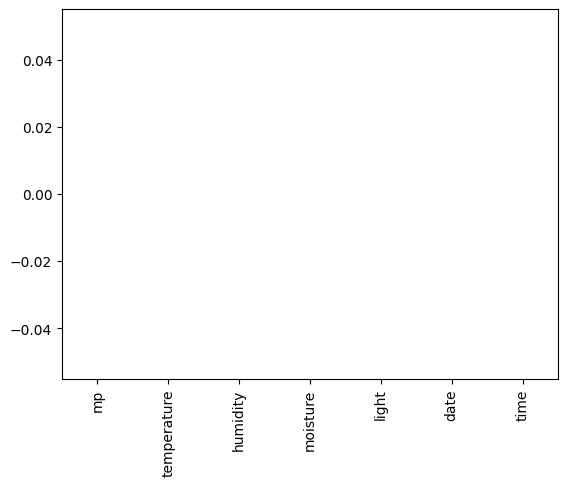

In [13]:
#check for missing value
sensor_df.isna().sum().plot.bar()


**Interpretation:**
The dataset does not have any missing value.

###**Identify Duplicate records,if any**

In [14]:
sensor_df.duplicated().sum()

0

**Interpretation**

There are no duplicate records available in the dataset. It shows the great connectivity with the on-field equipment and cloud infrastructure.

###**Check unique values for various dimension field(mp)**

This is required to understand the usefulness of the field in the overall modeliing process

In [15]:
sensor_df['mp'].nunique()

1

**Interpretation:**
Since mp column holds only one unique values, it can be safely deleted as a part of EDA.

In [16]:
sensor_df.head()

,mp,temperature,humidity,moisture,light,date,time
0,n1,24.7,57.9,1995,0.0,2022-09-15,00:00:04
1,n1,24.7,58.0,1991,0.0,2022-09-15,00:00:09
2,n1,24.7,58.2,1994,0.0,2022-09-15,00:00:14
3,n1,24.6,58.0,1993,0.0,2022-09-15,00:00:19
4,n1,24.6,58.0,1986,0.0,2022-09-15,00:00:25


In [17]:
column_names = ['temperature', 'humidity', 'moisture', 'light']
#sensor_df.plot(x='time', y=column_names, subplots=True, figsize=(15, 10))
sensor_wo_mp_df = sensor_df.drop(columns=['mp'])

In [18]:
sensor_wo_mp_df['msmt_taken_time'] = pd.to_datetime(sensor_wo_mp_df['date'] + ' ' + sensor_wo_mp_df['time'], format = '%Y-%m-%d %H:%M:%S')
sensor_wo_mp_df['hour'] = sensor_wo_mp_df['msmt_taken_time'].dt.hour
sensor_wo_mp_df['day'] = sensor_wo_mp_df['msmt_taken_time'].dt.day
sensor_wo_mp_df['month'] = sensor_wo_mp_df['msmt_taken_time'].dt.month



In [19]:
#View the first few records to get familiar with the data.
sensor_wo_mp_df.head()

,temperature,humidity,moisture,light,date,time,msmt_taken_time,hour,day,month
0,24.7,57.9,1995,0.0,2022-09-15,00:00:04,2022-09-15 00:00:04,0,15,9
1,24.7,58.0,1991,0.0,2022-09-15,00:00:09,2022-09-15 00:00:09,0,15,9
2,24.7,58.2,1994,0.0,2022-09-15,00:00:14,2022-09-15 00:00:14,0,15,9
3,24.6,58.0,1993,0.0,2022-09-15,00:00:19,2022-09-15 00:00:19,0,15,9
4,24.6,58.0,1986,0.0,2022-09-15,00:00:25,2022-09-15 00:00:25,0,15,9


In [20]:
print("Data collected for month: %d"%sensor_wo_mp_df['month'].unique())
print("Data collected for days: ", sensor_wo_mp_df['day'].unique())
print("Data collected for hours: " , sensor_wo_mp_df['hour'].unique())


Data collected for month: 9
Data collected for days:  [15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Data collected for hours:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


**Interpretation**

The dataset contains data for 14 days in Sept 2022 month. The data has been collected 24 hours a day.

##**Check for Data skewness**

Events per hour
hour
4     9793
6     9783
23    9780
5     9779
9     9773
12    9765
11    9763
7     9762
8     9759
10    9754
19    9752
16    9752
17    9752
18    9747
21    9742
13    9741
22    9739
0     9736
14    9735
15    9734
20    9728
3     9720
2     9713
1     9678
Name: count, dtype: int64


<Axes: xlabel='hour'>

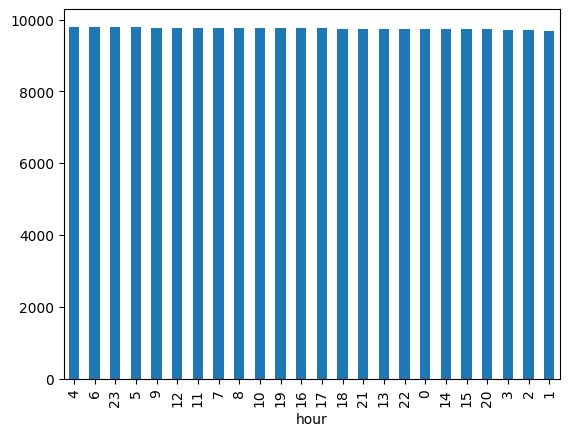

In [21]:
print("Events per hour")
print(sensor_wo_mp_df.hour.value_counts())
sensor_wo_mp_df.hour.value_counts().plot.bar()

Events per days
day
15    16950
16    16946
18    16767
19    16766
20    16735
27    16697
17    16688
23    16682
21    16656
22    16652
24    16649
26    16628
25    16587
28    16577
Name: count, dtype: int64


<Axes: xlabel='day'>

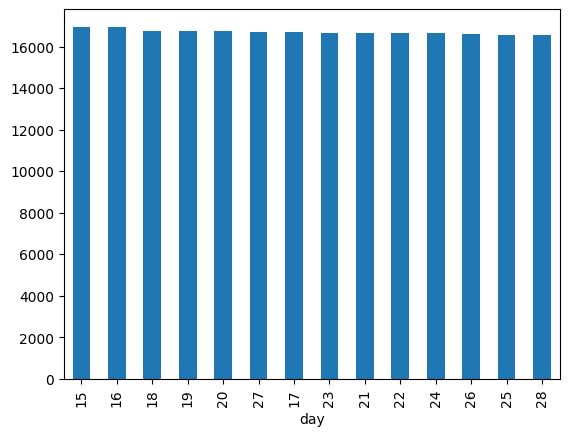

In [22]:
print("Events per days")
print(sensor_wo_mp_df.day.value_counts())
sensor_wo_mp_df.day.value_counts().plot.bar()

##**Interpretation**

The data is continous and evenly distributed at day and hour level. There is no skews while sourcing the data. It looks like all sensors are perfectly operational.

This is a sequential data.

##**Identify data collection frequency**

In [23]:
sensor_wo_mp_df['diff'] = sensor_wo_mp_df['msmt_taken_time'].diff()
sensor_wo_mp_df['diff'].value_counts().head()

,count
diff,
0 days 00:00:05,198169
0 days 00:00:06,34764
0 days 00:00:10,392
0 days 00:00:07,316
0 days 00:00:08,86


##**Interpretation**

Majority of the data is collected in every seconds. This will be useful when selecting appropriate prediction horizon(ph).

In [24]:
#Will be deleted.
#sensor_df.info()
#https://www.kaggle.com/datasets/wisam1985/iot-agriculture-2024/data
#https://www.kaggle.com/code/joanpau/iot-farming-crops-soils/notebook - a lot of EDA example
#https://thecleverprogrammer.com/2024/03/11/multivariate-time-series-forecasting-using-python/


###**Visualise the pattern of the data against time**

array([<Axes: xlabel='msmt_taken_time'>, <Axes: xlabel='msmt_taken_time'>,
       <Axes: xlabel='msmt_taken_time'>, <Axes: xlabel='msmt_taken_time'>],
      dtype=object)

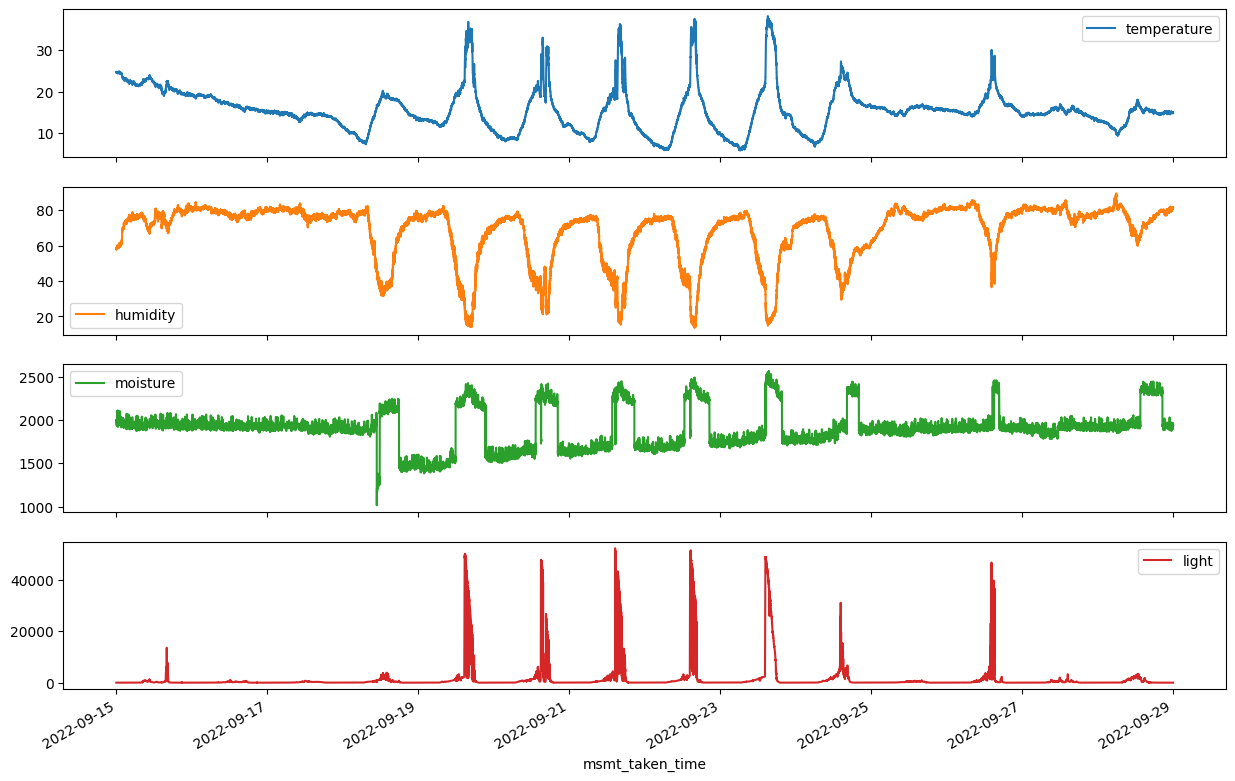

In [25]:
column_names = ['temperature', 'humidity', 'moisture', 'light']
sensor_wo_mp_df.plot(x='msmt_taken_time', y=column_names, subplots=True, figsize=(15, 10))

**Interpretation**

When temperature is on higher side, humidity is less and vice verse.  Similarly, temperature and moisture and light follows a pattern. At night, intensity of the light drops along witht the temperature and humidity. The tempature is high when the light intensity is high; in the day time.

In [26]:
temp_hourly_avg=sensor_wo_mp_df.groupby('hour')['temperature'].mean()
humdity_hourly_avg=sensor_wo_mp_df.groupby('hour')['humidity'].mean()
moisture_hourly_avg=sensor_wo_mp_df.groupby('hour')['moisture'].mean()
light_hourly_avg =sensor_wo_mp_df.groupby('hour')['light'].mean()


In [27]:
def visualise(input, x_label, y_label, title, x_range):
  plt.figure(figsize=(5, 2))
  plt.plot(input.index, input.values )
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.xticks(range(min(x_range) , max(x_range)+1, 1))  # Set x-axis ticks for each hour
  plt.grid(False)
  plt.show()


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


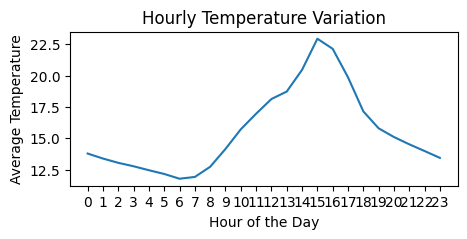

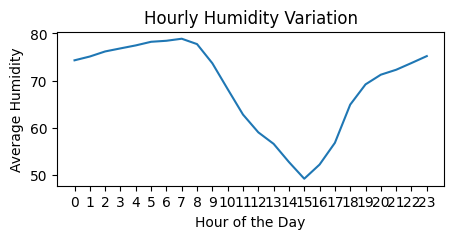

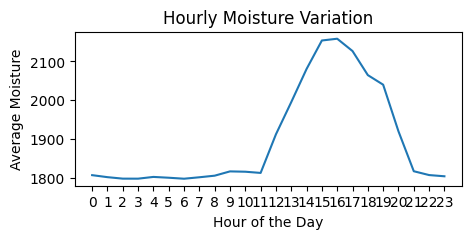

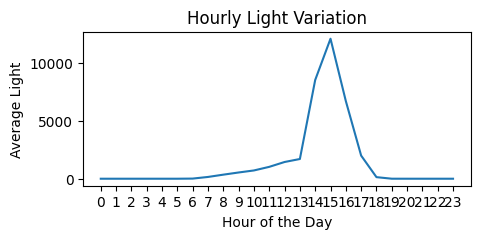

In [28]:
unique_hours = sensor_wo_mp_df['hour'].unique()
print(unique_hours)
visualise(temp_hourly_avg, 'Hour of the Day', 'Average Temperature', 'Hourly Temperature Variation', unique_hours)
visualise(humdity_hourly_avg, 'Hour of the Day', 'Average Humidity', 'Hourly Humidity Variation', unique_hours)
visualise(moisture_hourly_avg, 'Hour of the Day', 'Average Moisture', 'Hourly Moisture Variation', unique_hours)
visualise(light_hourly_avg, 'Hour of the Day', 'Average Light', 'Hourly Light Variation', unique_hours)

**Interpretation**

We have plotted how temperature, moisture, light and humidity varies in 24 hours window during these 15 days.

It can be concluded from the above graphs that
1.  The highest temperature is attained at ~3 pm when the light intensity is highest reflecting normal pattern. Avg humidity in the air is least at this time.

2. Moisture in the soil is least up to 8 am in the morning. After that, moisture starts to increase possible water is supplied. It peaks at 3 pm and its level drops again.


In [29]:
temp_daily_avg=sensor_wo_mp_df.groupby('day')['temperature'].mean()
humdity_daily_avg=sensor_wo_mp_df.groupby('day')['humidity'].mean()
moisture_daily_avg=sensor_wo_mp_df.groupby('day')['moisture'].mean()
light_daily_avg =sensor_wo_mp_df.groupby('day')['light'].mean()

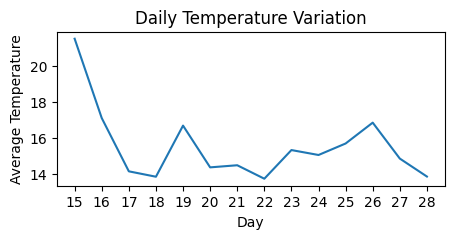

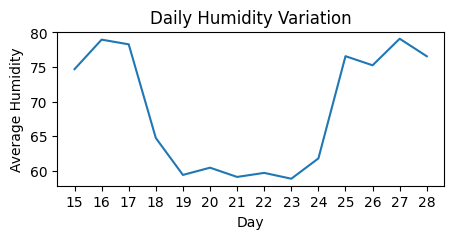

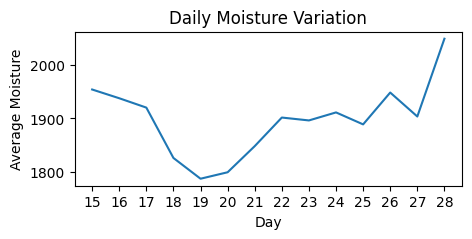

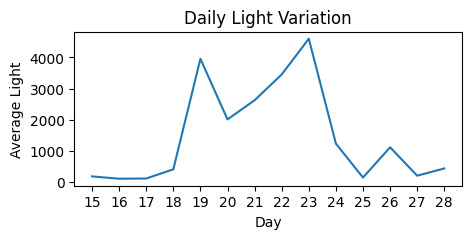

In [30]:
unique_day = sensor_wo_mp_df['day'].unique()
visualise(temp_daily_avg, 'Day', 'Average Temperature', 'Daily Temperature Variation',unique_day)
visualise(humdity_daily_avg, 'Day', 'Average Humidity', 'Daily Humidity Variation',unique_day)
visualise(moisture_daily_avg, 'Day', 'Average Moisture', 'Daily Moisture Variation',unique_day)
visualise(light_daily_avg, 'Day', 'Average Light', 'Daily Light Variation',unique_day)

**Interpretation**

The temperature was on a higher side for the first day and remain low for the other days.

Overall humidity in air was on higher sider for first and last few days whereas it was low on other days.

Moisture on soil was lowest on 19th and 20th and highest on 28th. This pattern does not look right. One of the reasons could be less water was supplied during these days and more water was supplied on 28th. <b> With appropriate forecasting, this could have been avoided.</b>




##**Check for outliers**



In [31]:
def check_outliers(df, column):
  # Calculate quantiles and IQR
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  # Define upper and lower bounds for outliers
  upper_bound = Q3 + 1.5 * IQR
  lower_bound = Q1 - 1.5 * IQR

  # Identify outliers
  outliers = df[(df[column] > upper_bound) | (df[column] < lower_bound)]

  # Visualize outliers with box plot
  sns.boxplot(x=df[column])
  plt.title(f'Box Plot of {column} (Outliers Detected)')
  plt.show()

  # Print outlier information
  print(f'Number of outliers in {column}: {len(outliers)}')
  print(f'Outliers:\n{outliers}')

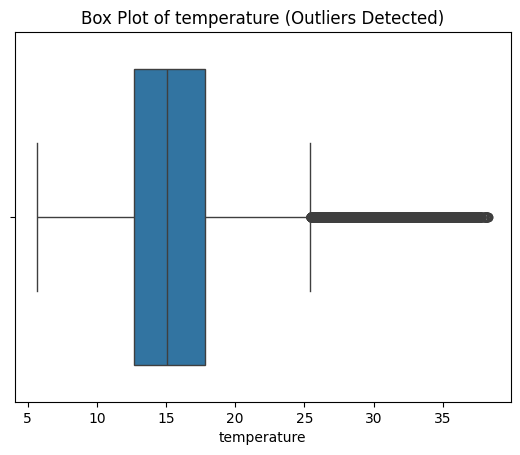

Number of outliers in temperature: 8562
Outliers:
        temperature  humidity  moisture     light        date      time  \
77698          25.5      23.9      2302  48650.00  2022-09-19  14:48:50   
77699          25.6      24.4      2304  49063.33  2022-09-19  14:48:55   
77700          25.7      24.6      2305  48755.83  2022-09-19  14:49:00   
77701          25.7      24.6      2304  48855.00  2022-09-19  14:49:05   
77702          25.7      24.3      2307  48744.16  2022-09-19  14:49:10   
...             ...       ...       ...       ...         ...       ...   
194672         25.6      44.7      2384   1257.50  2022-09-26  15:17:48   
194673         25.6      45.0      2411   1317.50  2022-09-26  15:17:54   
194674         25.6      45.1      2385   1379.17  2022-09-26  15:17:59   
194675         25.5      45.2      2384   1464.17  2022-09-26  15:18:04   
194676         25.5      45.0      2378   1559.17  2022-09-26  15:18:09   

           msmt_taken_time  hour  day  month     

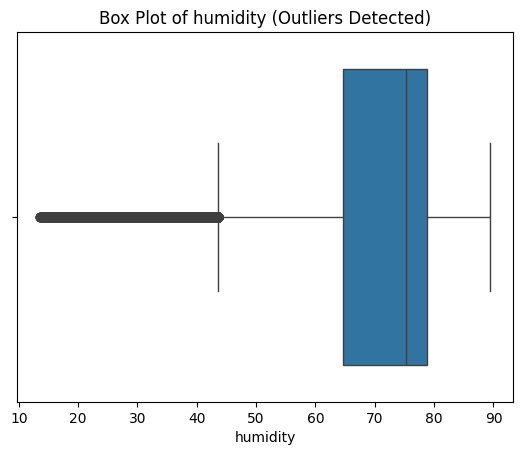

Number of outliers in humidity: 24844
Outliers:
        temperature  humidity  moisture    light        date      time  \
58207          16.4      43.2      1203   909.17  2022-09-18  10:52:50   
58208          16.4      43.3      1215   909.17  2022-09-18  10:52:55   
58212          16.4      43.4      1252   911.67  2022-09-18  10:53:16   
58213          16.4      43.3      1210   912.50  2022-09-18  10:53:21   
58214          16.4      43.5      1212   913.33  2022-09-18  10:53:26   
...             ...       ...       ...      ...         ...       ...   
194659         26.4      42.5      2391  1220.83  2022-09-26  15:16:41   
194660         26.4      43.1      2389  1222.50  2022-09-26  15:16:46   
194661         26.3      43.1      2389  1227.50  2022-09-26  15:16:52   
194662         26.2      43.3      2387  1233.33  2022-09-26  15:16:57   
194663         26.1      43.3      2385  1229.17  2022-09-26  15:17:02   

           msmt_taken_time  hour  day  month            diff  


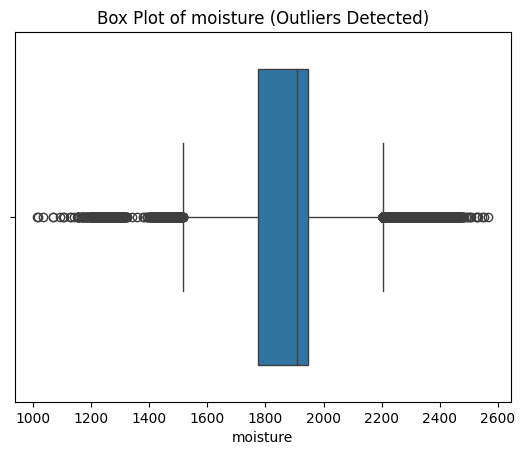

Number of outliers in moisture: 42330
Outliers:
        temperature  humidity  moisture   light        date      time  \
58154          16.2      45.9      1068  245.00  2022-09-18  10:48:17   
58155          16.2      46.5      1035  270.83  2022-09-18  10:48:22   
58156          16.3      47.2      1015  276.67  2022-09-18  10:48:28   
58157          16.4      47.3      1017  214.17  2022-09-18  10:48:33   
58158          16.5      48.4      1067  266.67  2022-09-18  10:48:38   
...             ...       ...       ...     ...         ...       ...   
231610         14.7      79.5      2325    0.00  2022-09-28  20:34:49   
231611         14.7      79.5      2333    0.00  2022-09-28  20:34:54   
231612         14.7      79.5      2325    0.00  2022-09-28  20:34:59   
231613         14.7      79.5      2330    0.00  2022-09-28  20:35:04   
231614         14.7      79.5      2334    0.00  2022-09-28  20:35:10   

           msmt_taken_time  hour  day  month            diff  
58154  2022-

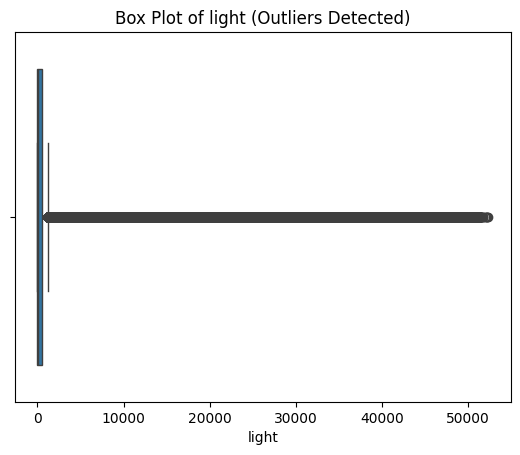

Number of outliers in light: 31364
Outliers:
        temperature  humidity  moisture    light        date      time  \
7413           23.7      68.1      1969  1220.83  2022-09-15  10:29:45   
7414           23.6      68.1      1963  1226.67  2022-09-15  10:29:50   
11130          20.7      72.4      1949  1227.50  2022-09-15  15:45:05   
11131          20.8      72.6      1953  1260.00  2022-09-15  15:45:10   
11132          20.7      72.6      1945  1298.33  2022-09-15  15:45:16   
...             ...       ...       ...      ...         ...       ...   
227785         15.5      70.8      2343  1274.17  2022-09-28  15:03:20   
227786         15.5      71.0      2378  1260.83  2022-09-28  15:03:25   
227787         15.5      71.1      2343  1247.50  2022-09-28  15:03:30   
227788         15.5      71.0      2343  1234.17  2022-09-28  15:03:35   
227789         15.5      70.8      2339  1221.67  2022-09-28  15:03:40   

           msmt_taken_time  hour  day  month            diff  
741

In [32]:
for col in ['temperature', 'humidity', 'moisture', 'light']:
  check_outliers(sensor_wo_mp_df, col)

**Interpretation**


In [33]:

def check_spread(df, column):
  mean = sum(df[column]) / len(df[column])
  median = sorted(df[column])[len(df[column]) // 2]

  sns.histplot(data=df, x=column, bins=25, kde=True, edgecolor="black",color='#251188',facecolor='#f1b27b')

  plt.axvline(mean, color='r', linestyle='--', label='mean')
  plt.axvline(median, color='g', linestyle='--', label='median')


  plt.legend()

  plt.show()


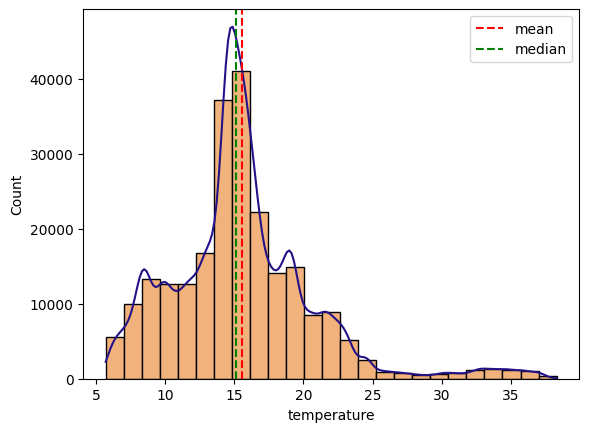

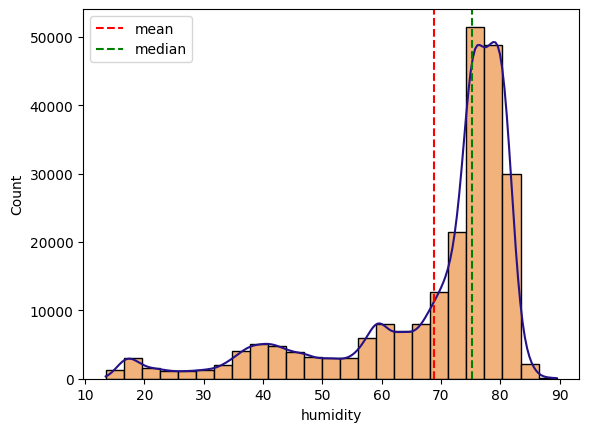

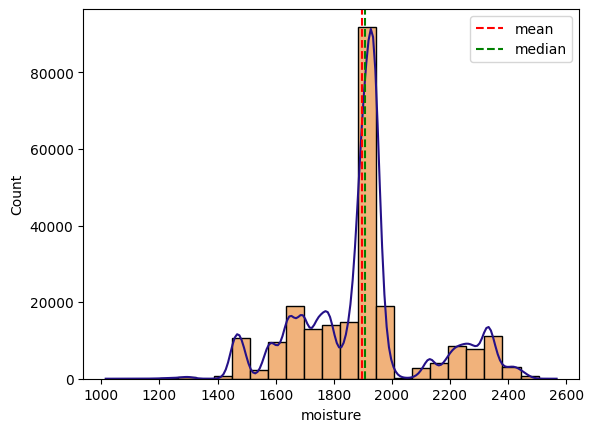

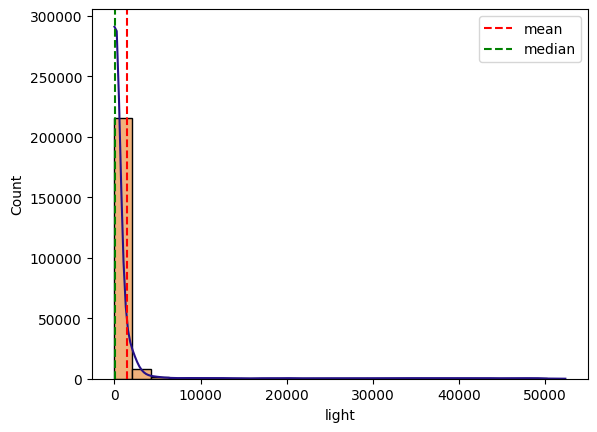

In [34]:
for col in ['temperature', 'humidity', 'moisture', 'light']:
  check_spread(sensor_wo_mp_df, col)

<Axes: >

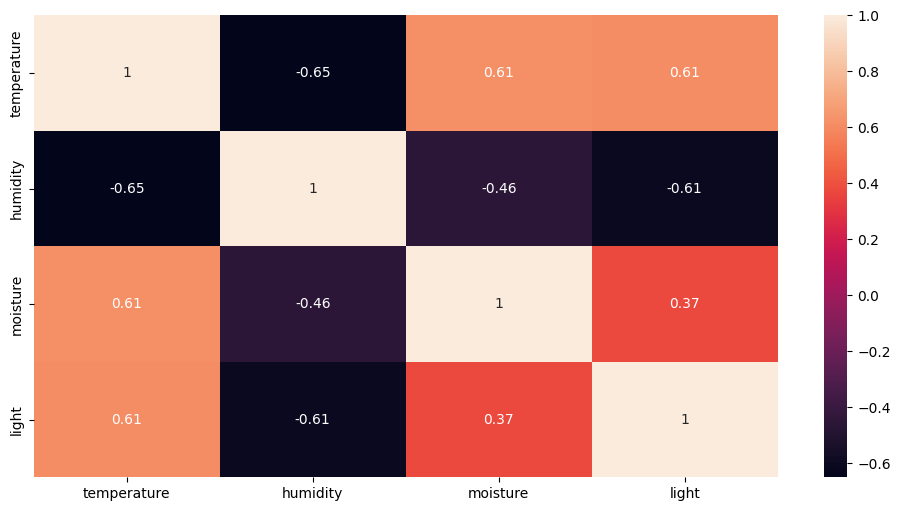

In [35]:
#Identify the correrelations
corr_df = sensor_df[['temperature', 'humidity', 'moisture', 'light']]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_df.corr(),annot=True)

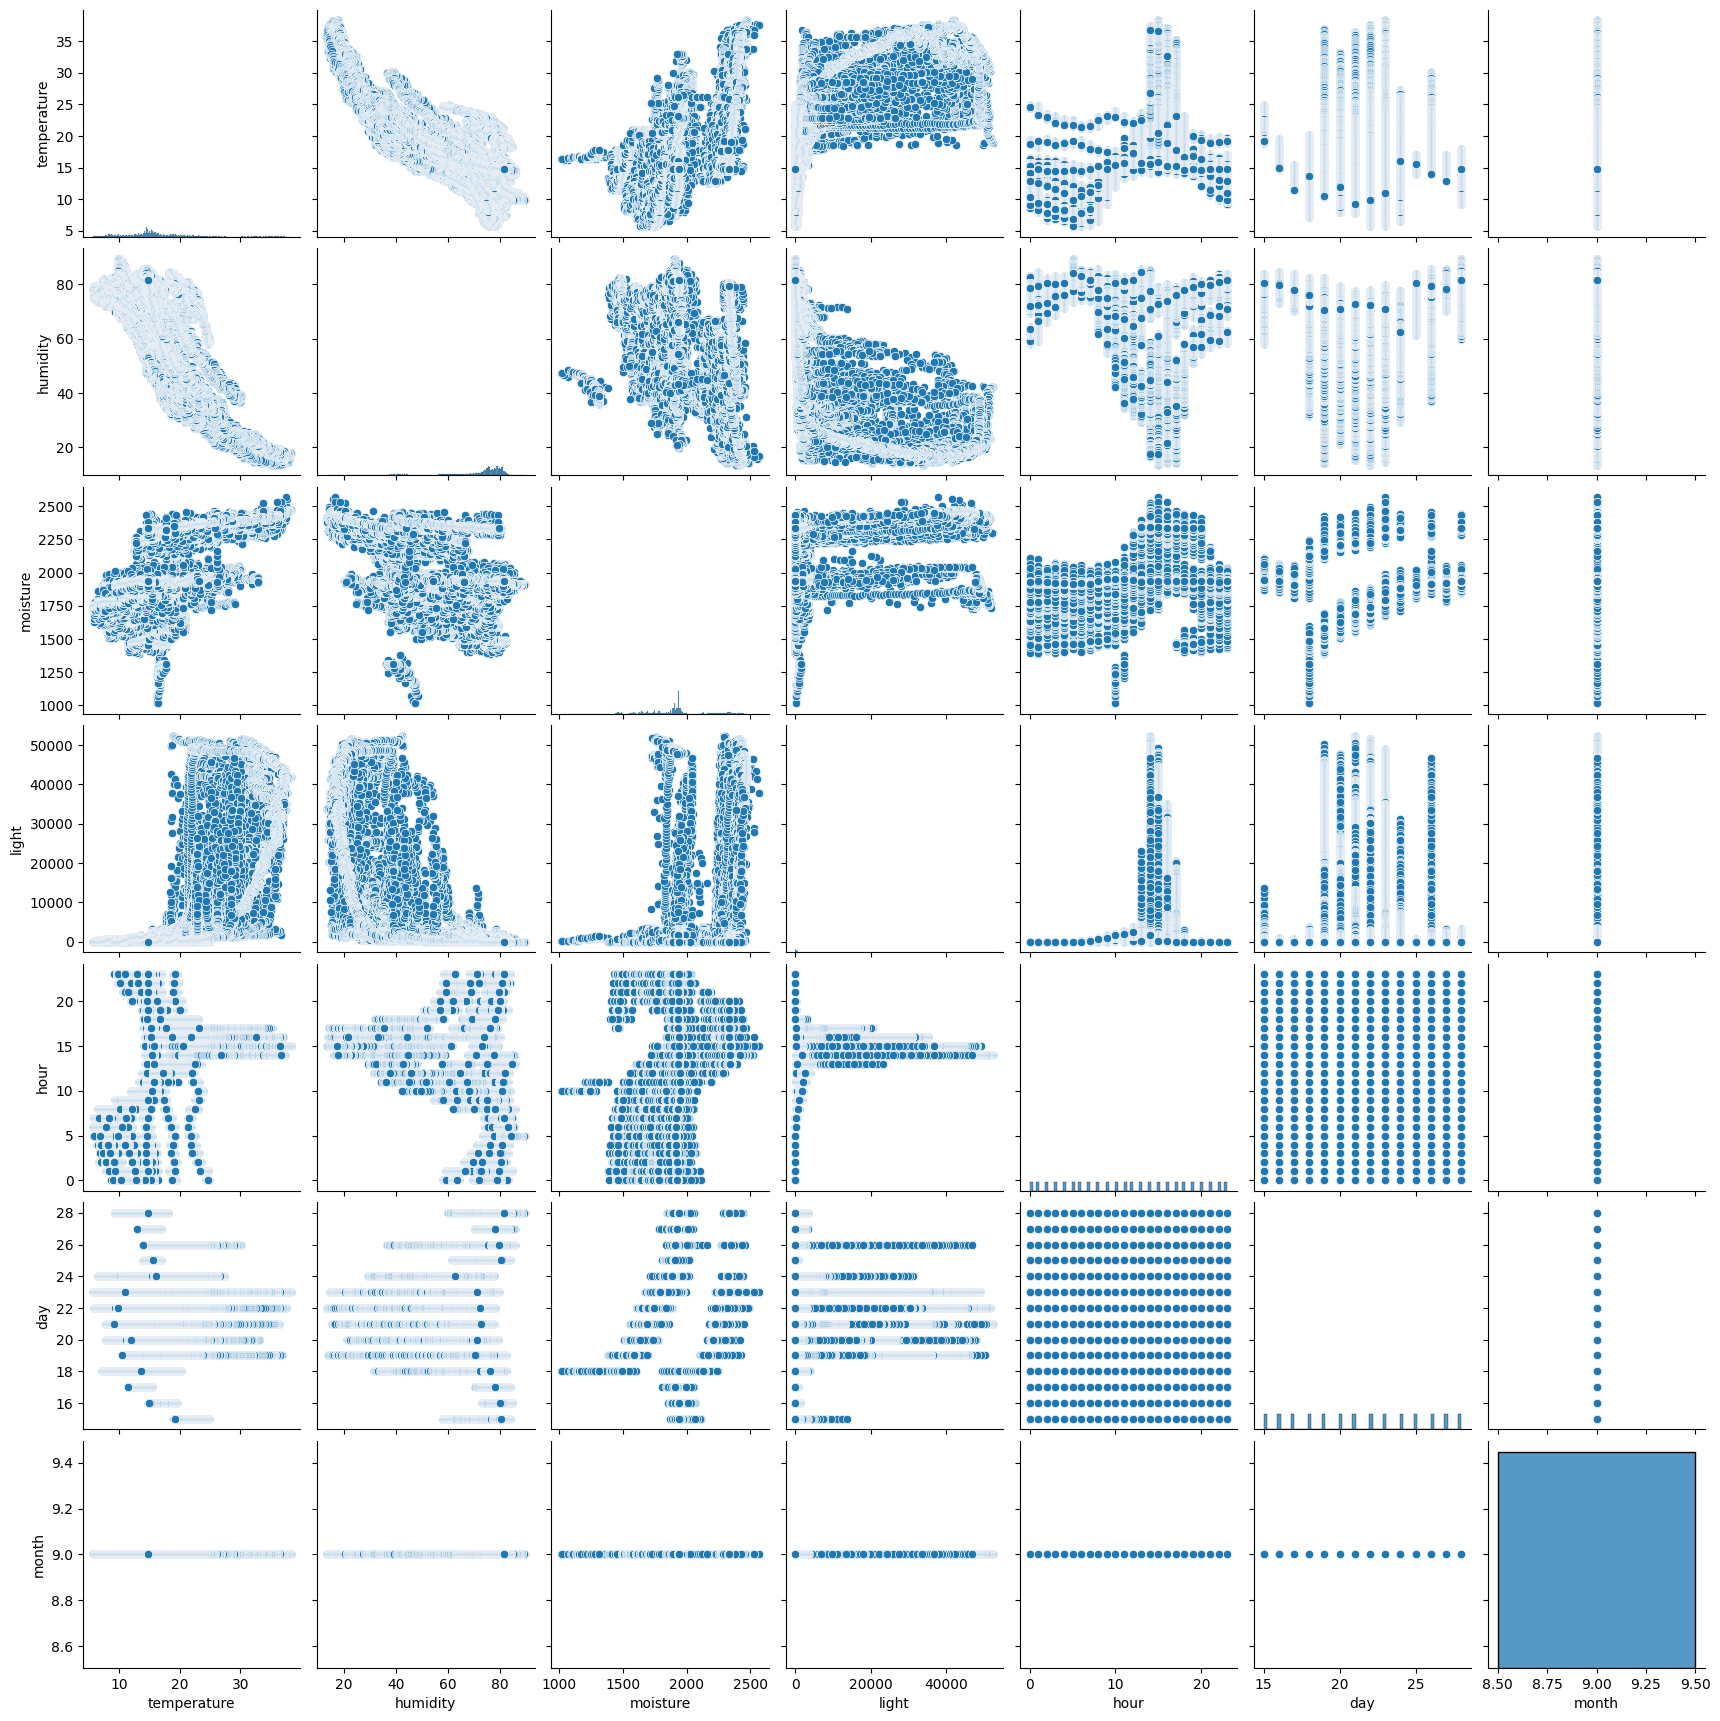

In [36]:
sns.pairplot(sensor_wo_mp_df)
plt.show()

#**Preprocessing , Training and Validation split and Scaling**


In [37]:
sensor_wo_mp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233980 entries, 0 to 233979
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   temperature      233980 non-null  float64        
 1   humidity         233980 non-null  float64        
 2   moisture         233980 non-null  int64          
 3   light            233980 non-null  float64        
 4   date             233980 non-null  object         
 5   time             233980 non-null  object         
 6   msmt_taken_time  233980 non-null  datetime64[ns] 
 7   hour             233980 non-null  int32          
 8   day              233980 non-null  int32          
 9   month            233980 non-null  int32          
 10  diff             233979 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), float64(3), int32(3), int64(1), object(2), timedelta64[ns](1)
memory usage: 17.0+ MB


**Identify if there are any null value in the difference of two timestamp while calculating the frequency of data ingestion**

In [38]:
sensor_wo_mp_df['diff'].isnull().sum()


1

**Replace null value in diff column with zero.**

In [39]:
sensor_wo_mp_df['diff'].fillna(pd.Timedelta(seconds=0), inplace=True)
sensor_wo_mp_df['diff'] = pd.to_timedelta(sensor_wo_mp_df['diff'])

sensor_wo_mp_df['diff_sec'] = sensor_wo_mp_df['diff'].dt.total_seconds().astype(int)
freq_ingestion = math.ceil(sensor_wo_mp_df['diff_sec'].mean())

print("Frequency of the data ingestion is every %d sec"%(freq_ingestion))

Frequency of the data ingestion is every 6 sec


**Convert datetime to epoch/unix time**

In [40]:
#convert datetime to epoch/unix time
sensor_wo_mp_df['epoch_time'] = pd.to_datetime(sensor_wo_mp_df['msmt_taken_time']).astype(np.int64)/(10**10)
sensor_wo_mp_df['epoch_time'] = sensor_wo_mp_df['epoch_time'].astype(int)
sensor_wo_mp_df['epoch_time'].count()

233980

Setting Prediction Horizon(ph) and mu for importance on dataset recency

Lets consider that our model can predict moisture in soil for next one hour. we will consider mu as 0.9 to start with to provide more weightage on the recent records.

In [41]:
ts = pd.DataFrame(sensor_wo_mp_df.epoch_time)
ys = pd.DataFrame(sensor_wo_mp_df.moisture)

ph = 60*60 #Converted Minutes to seconds since the frequency
ph_index = math.ceil(ph/freq_ingestion)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [42]:
# At every iteration of the for loop a new data sample is acquired
def execute_model(mu, ts, ys):
  for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp =  model_tmp.coef_
    q_tmp =  model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]
    yp = m_tmp*tp  + q_tmp

    #tp_pred[i-2] = tp + ph
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

In [60]:
def visualise_results(startpoint, lastpoint , ts, ys, tp_pred, yp_pred, data_points='for first 200 datapoints'):
  fig, ax = plt.subplots(figsize=(10,5))
  title = 'Soil Moisture Prediction %s' %(data_points)
  fig.suptitle(title, fontsize=14, fontweight='bold')
  ax.set_title('mu = %g, ph=%g ' %(mu, ph))
  ax.plot(tp_pred[startpoint:lastpoint], yp_pred[startpoint:lastpoint], label='Predicted Value')
  ax.plot(ts.iloc[startpoint:lastpoint,0], ys.iloc[startpoint:lastpoint,0], label='Soil Moisture Data')
  ax.set_xlabel('time (epoch)')
  ax.set_ylabel('Moisture')
  ax.legend()

In [44]:
def plot_result_mse(ts,ys, tp_pred, yp_pred):
  visualise_results(0, n_s-1, ts, ys, tp_pred, yp_pred, 'for first 200 datapoints')
  visualise_results(n_s-2000, n_s, ts, ys, tp_pred, yp_pred, 'for last 200 datapoints')
  #Calculate MSE of predictions
  print("MSE is", mse(ys['moisture'][ph_index:n_s+ph_index-1],yp_pred))


In [45]:
execute_model(mu,ts,ys)

MSE is 47.701269866188866


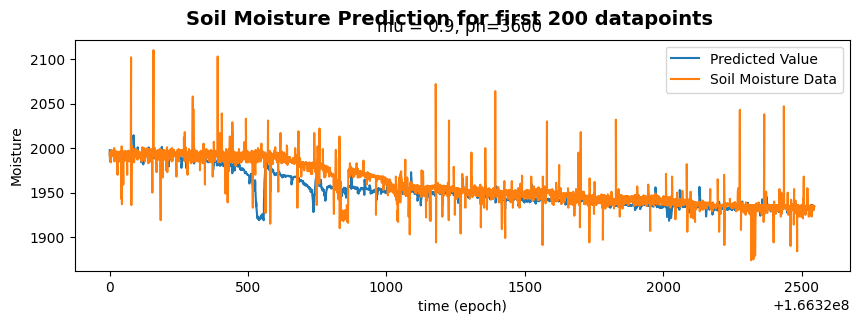

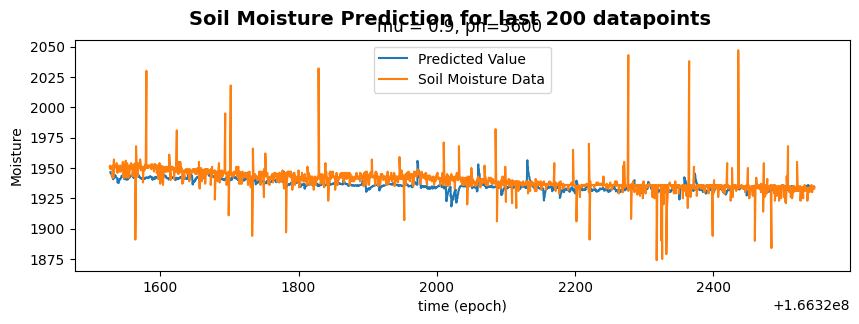

In [46]:
plot_result_mse(ts, ys, tp_pred, yp_pred)

In [47]:
#Re-run prediction code for mu = 1
mu=1
execute_model(mu,ts,ys)

MSE is 136.20987158793673


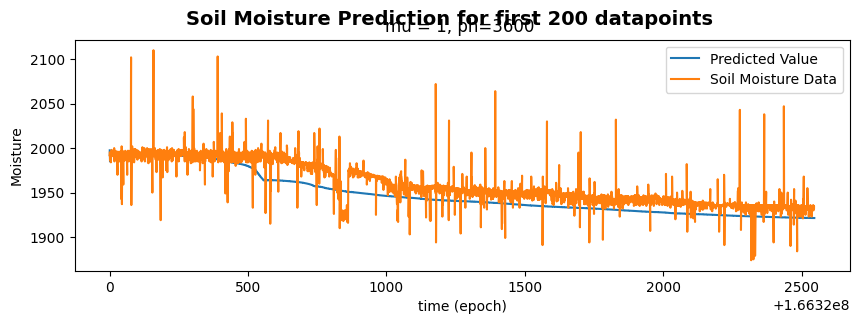

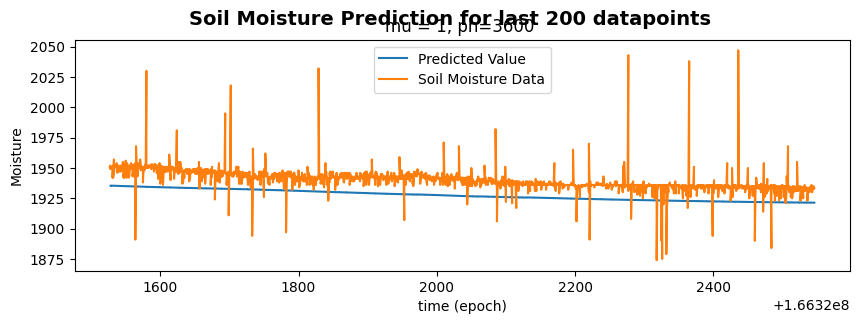

In [48]:
plot_result_mse(ts, ys, tp_pred, yp_pred)

In [49]:
#Re-run prediction code for mu = 0.01
mu=0.01
execute_model(mu,ts,ys)

MSE is 0.005880701169365315


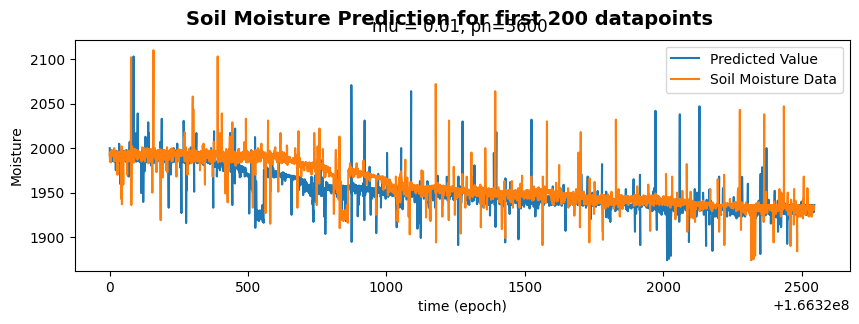

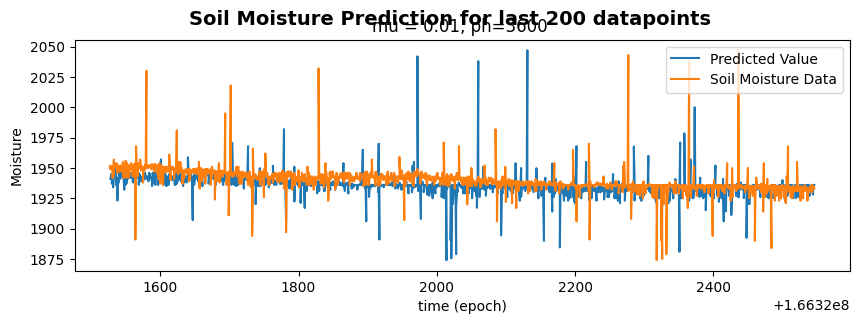

In [50]:
plot_result_mse(ts, ys, tp_pred, yp_pred)

##**Interpretation**

<table>
<tr>
      <td> Sel No </td>
      <td> MU
      <td> MSE error
</tr>

<tr>
      <td> 1 </td>
      <td> 0.9
      <td> 47.7
</tr>

<tr>
      <td> 2 </td>
      <td> 1.0
      <td> 136.2
</tr>
<tr>
      <td> 3 </td>
      <td> 0.01
      <td> 0.06
</tr>

</table>

It is evident that the model prediction was lagging in the beginning. As the training progresses, the model learns more and prediction started following the actual output very closely.

MSE error is the least when mu is kept 0.01. We will baseline mu =0.01

In [51]:
sensor_wo_mp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233980 entries, 0 to 233979
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   temperature      233980 non-null  float64        
 1   humidity         233980 non-null  float64        
 2   moisture         233980 non-null  int64          
 3   light            233980 non-null  float64        
 4   date             233980 non-null  object         
 5   time             233980 non-null  object         
 6   msmt_taken_time  233980 non-null  datetime64[ns] 
 7   hour             233980 non-null  int32          
 8   day              233980 non-null  int32          
 9   month            233980 non-null  int32          
 10  diff             233980 non-null  timedelta64[ns]
 11  diff_sec         233980 non-null  int64          
 12  epoch_time       233980 non-null  int64          
dtypes: datetime64[ns](1), float64(3), int32(3), int64(3), objec

##**Explore with multiple input variables.



In [61]:
def initialize_multivariate(mu):
  ts_mv = sensor_wo_mp_df[['epoch_time', 'temperature','humidity' ,'light' ]]
  ys_mv = pd.DataFrame(sensor_wo_mp_df.moisture)

  ph = 5 * 60   #5 minutes
  ph_index = math.ceil(ph/freq_ingestion)
  mu = 0.01

  #let's limit the number of samples in our model to 5000 just for speed
  n_s = 5000

  #arrays to hold predicted values
  tp_mv_pred = np.zeros(n_s-1)
  yp_mv_pred = np.zeros(n_s-1)
  return ts_mv, ys_mv, tp_mv_pred, yp_mv_pred

In [53]:
def execute_model1(mu, ts, ys, is_multi_variate=False):
  for i in range(2, n_s + 1):  # start out with 2 leading datapoints
    # get x and y data "available" for our prediction
    if is_multi_variate:
      # Create ts_tmp with correct number of rows
      ts_tmp = pd.DataFrame({'epoch_time': ts['epoch_time'][0:i], 'temperature': ts['temperature'][0:i]
                             , 'humidity': ts['humidity'][0:i] , 'light': ts['light'][0:i]})
    else:
      ts_tmp = ts[0:i]

    # Fix: Use the same range for slicing ys_tmp to match ts_tmp
    ys_tmp = ys[0:i]

    ns = len(ys_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
      # adjust weights to be downweighted according to their timestep away from our prediction
      weights[k] = weights[k] ** k
    weights = np.flip(weights, 0)

    # perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()

    # Changed to ts_tmp.values to provide numpy array to fit method
    model_tmp = lm_tmp.fit(ts_tmp.values, ys_tmp.values, sample_weight=weights)


    # store model coefficients and intercepts to compute prediction


    if is_multi_variate:
      m_tmp = model_tmp.coef_[0][0]
      m_temp_tmp = model_tmp.coef_[0][1]
      m_humd_tmp = model_tmp.coef_[0][2]
      m_light_tmp = model_tmp.coef_[0][3]

    else:
      m_tmp = model_tmp.coef_


    q_tmp = model_tmp.intercept_

    # use ph to make the model prediction according to the prediction time
    tp = ts['epoch_time'].iloc[i - 1]  # Assuming ts is a DataFrame

    if is_multi_variate:
        # Access the last values of 'unix' and 'Voltage' for prediction
        tp_epoch_time = ts['epoch_time'].iloc[i - 1]
        tp_temperature = ts['temperature'].iloc[i - 1]
        tp_humidity = ts['humidity'].iloc[i - 1]
        tp_light = ts['light'].iloc[i - 1]

        # Create a DataFrame with the new values
        yp = m_tmp * tp_epoch_time + m_temp_tmp * tp_temperature +  m_humd_tmp * tp_humidity + m_light_tmp * tp_light + q_tmp
    else:
        yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp

Running the multi variate model with mu 0.010000
MSE is 185.99613986239459
Running the multi variate model with mu 0.500000
MSE is 171.05848724424823
Running the multi variate model with mu 1.000000
MSE is 122.11359841812843


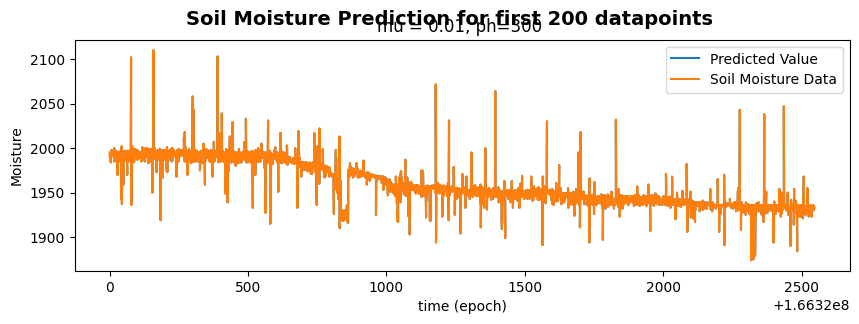

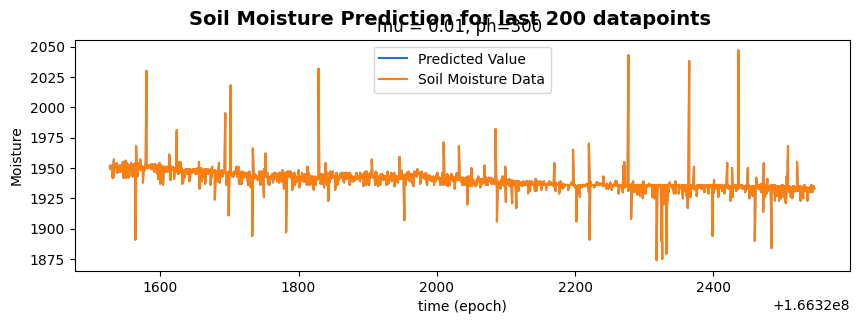

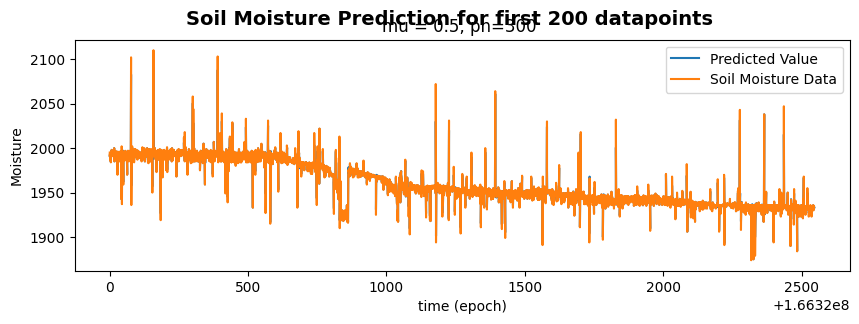

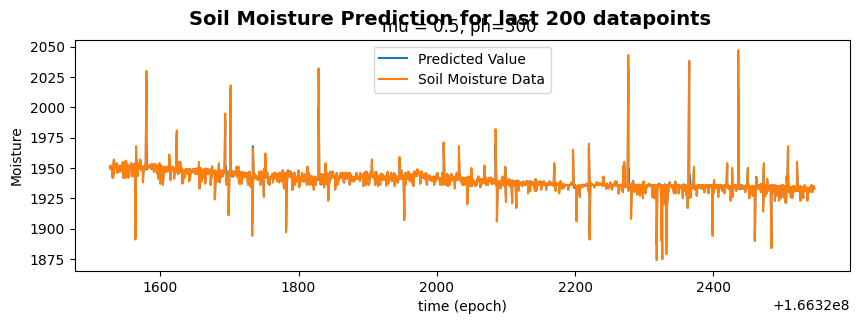

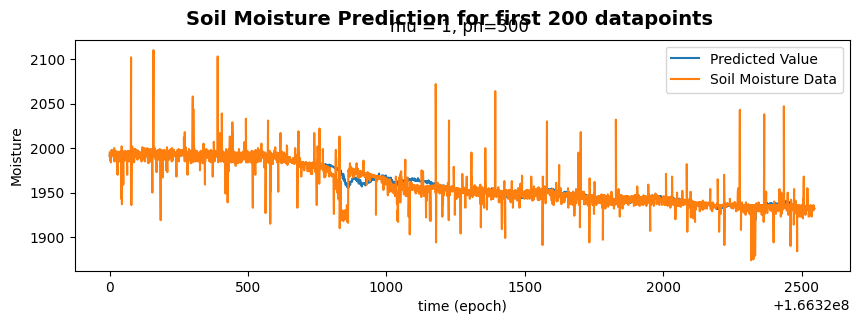

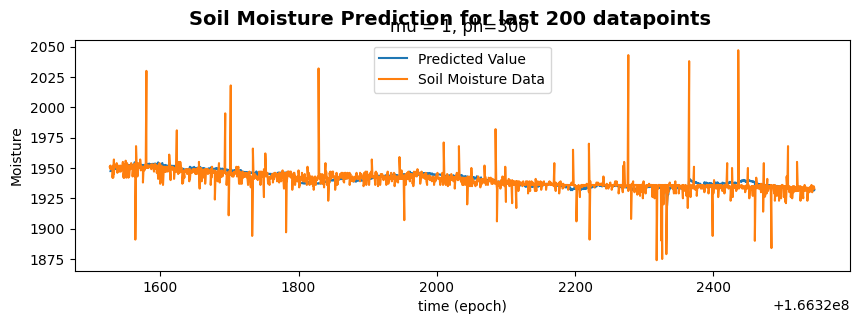

In [59]:
for mu in [0.01, 0.5, 1]:
  print("Running the multi variate model with mu %f"% mu )
  ts_mv, ys_mv, tp_mv_pred, yp_mv_pred = initialize_multivariate(mu)
  execute_model1(mu, ts_mv, ys_mv, is_multi_variate=True)
  plot_result_mse(ts, ys, tp_pred, yp_pred)


MSE is 185.99613986239459


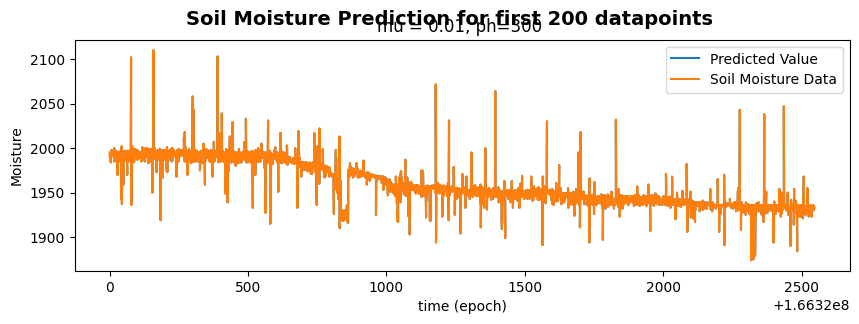

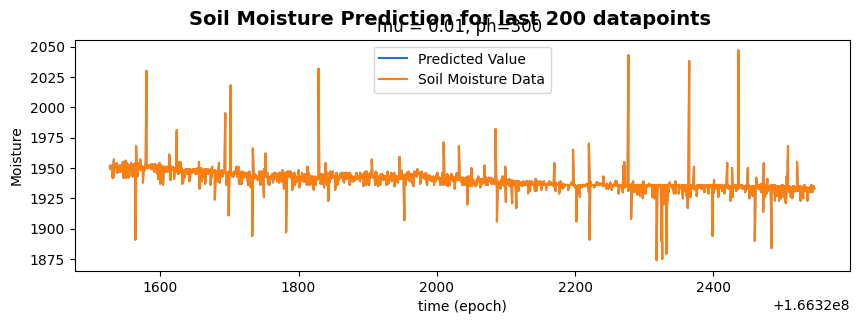

In [56]:
plot_result_mse(ts, ys, tp_pred, yp_pred)

##**Interpretation**

<table>
<tr>
      <td> Sel No </td>
      <td> MU
      <td> MSE error
</tr>

<tr>
      <td> 1 </td>
      <td> 0.5
      <td> 171.05
</tr>

<tr>
      <td> 2 </td>
      <td> 1.0
      <td> 122.11
</tr>
<tr>
      <td> 3 </td>
      <td> 0.01
      <td> 185.99
</tr>

</table>


Since the MSE for the multi variable analysis is very high. We will base line our analysis with single variate Linear regression with mu=0.01


### **HyperParameter Tuning**

In [74]:
ts = pd.DataFrame(sensor_wo_mp_df.epoch_time/60).astype(int)
ys = pd.DataFrame(sensor_wo_mp_df.moisture)

ph = 5 #Converted Minutes to seconds since the frequency
ph_index = math.ceil(ph/freq_ingestion)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [75]:
#Re-run prediction code for mu = 0.01
mu=0.01
execute_model(mu,ts,ys)

MSE is 0.013561363700886358


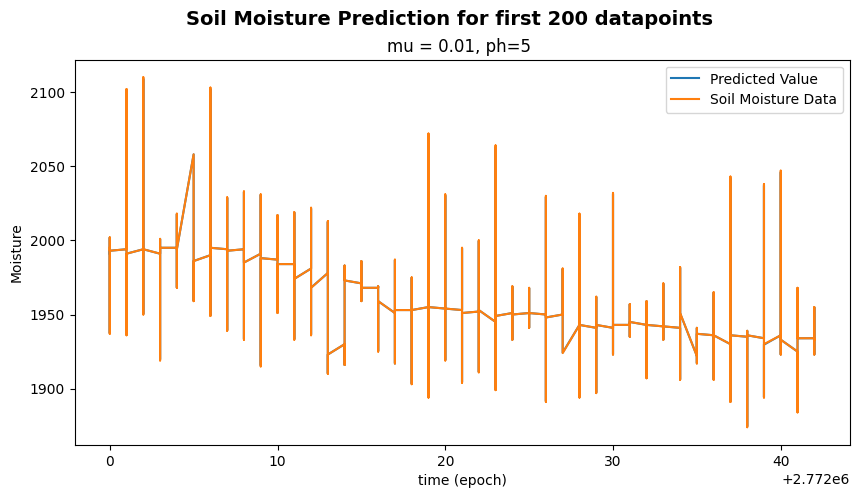

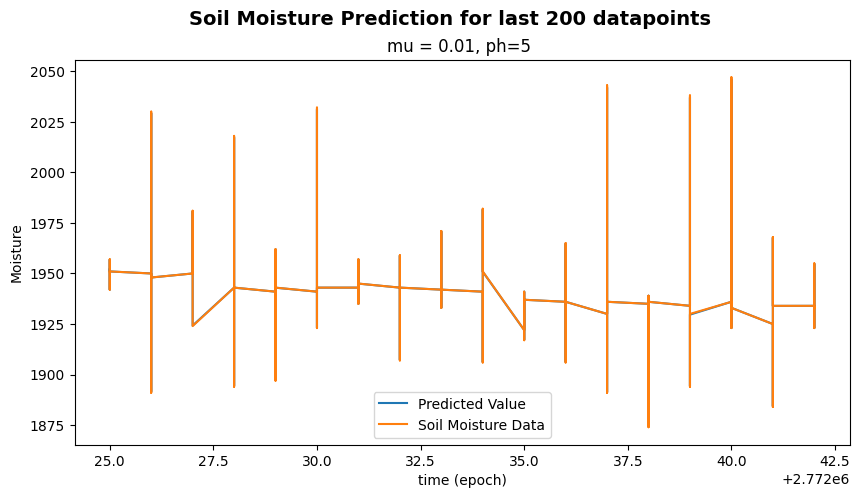

In [76]:
plot_result_mse(ts, ys, tp_pred, yp_pred)

##**Create moving average of the datapoint**

   temperature  humidity  moisture  light        date      time  \
0         24.7      57.9      1995    0.0  2022-09-15  00:00:04   
1         24.7      58.0      1991    0.0  2022-09-15  00:00:09   
2         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
3         24.6      58.0      1993    0.0  2022-09-15  00:00:19   
4         24.6      58.0      1986    0.0  2022-09-15  00:00:25   

      msmt_taken_time  hour  day  month            diff  diff_sec  epoch_time  \
0 2022-09-15 00:00:04     0   15      9 0 days 00:00:00         0   166320000   
1 2022-09-15 00:00:09     0   15      9 0 days 00:00:05         5   166320000   
2 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
3 2022-09-15 00:00:19     0   15      9 0 days 00:00:05         5   166320001   
4 2022-09-15 00:00:25     0   15      9 0 days 00:00:06         6   166320002   

   moisture_avg  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  


KeyError: 'moisture'

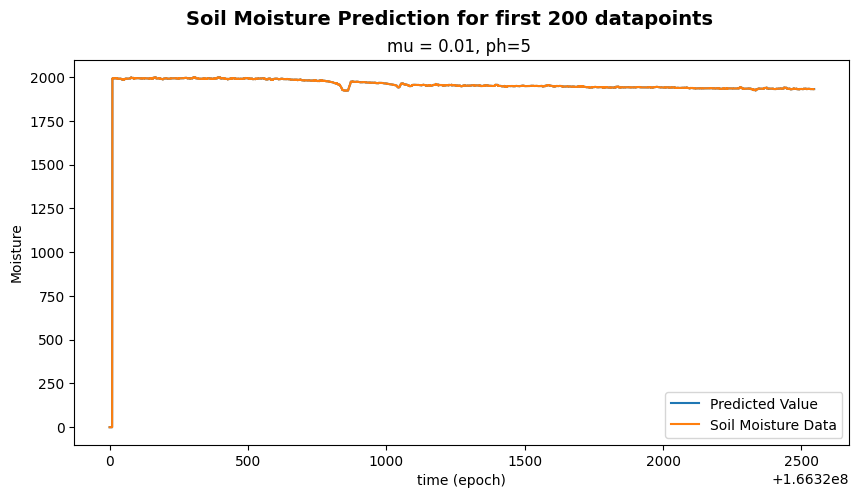

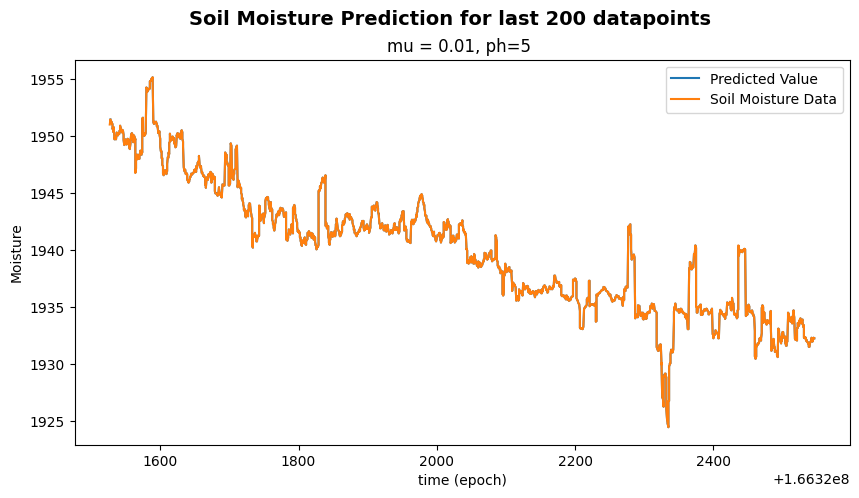

In [82]:
window_size = 20  # window size
sensor_wo_mp_df['moisture_avg'] = sensor_wo_mp_df['moisture'].rolling(window=window_size).mean()
print(sensor_wo_mp_df.head())
ys = pd.DataFrame(sensor_wo_mp_df.moisture_avg)
ys.fillna(0, inplace=True)


ts = pd.DataFrame(sensor_wo_mp_df.epoch_time)
# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)
execute_model(mu,ts,ys)
plot_result_mse(ts, ys, tp_pred, yp_pred)